In [33]:
!pip install gdown --quiet
!pip install scikit-learn --quiet

In [34]:
!gdown 1uFQbdN-O84XMEFCDaknseY-EH7uuUUMK
!mkdir data
!unzip -o databasebasketball.zip -d data
!rm databasebasketball.zip

Downloading...
From: https://drive.google.com/uc?id=1uFQbdN-O84XMEFCDaknseY-EH7uuUUMK
To: /content/databasebasketball.zip
100% 1.38M/1.38M [00:00<00:00, 88.3MB/s]
mkdir: cannot create directory ‘data’: File exists
Archive:  databasebasketball.zip
  inflating: data/team_season.txt    
  inflating: data/teams.txt          
  inflating: data/coaches_career.txt  
  inflating: data/coaches_season.txt  
  inflating: data/draft.txt          
  inflating: data/player_allstar.txt  
  inflating: data/player_playoffs.txt  
  inflating: data/player_playoffs_career.txt  
  inflating: data/player_regular_season.txt  
  inflating: data/player_regular_season_career.txt  
  inflating: data/players.txt        
  inflating: data/readme.txt         


In [35]:
# Loading the data
import pandas as pd
import numpy as np
team_season = pd.read_csv('data/team_season.txt')
player_season = pd.read_csv('data/player_regular_season.txt')
coaches_season = pd.read_csv('data/coaches_season.txt')
player_allstar = pd.read_csv('data/player_allstar.txt')
player_biological = pd.read_csv('data/players.txt')

print('Data loaded successfully!')
print('team_season shape:', team_season.shape)
print('player_season shape:', player_season.shape)
print('coaches_season shape:', coaches_season.shape)
print('player_allstar shape:', player_allstar.shape)
print('player_biological shape:', player_biological.shape)

Data loaded successfully!
team_season shape: (1187, 36)
player_season shape: (19112, 23)
coaches_season shape: (1241, 10)
player_allstar shape: (1462, 23)
player_biological shape: (3572, 11)


Intuitively we can see that some dimensions can be ignored or combined into a single metric. For example, height in feet and inches in feet can be combined into a single metric. Some features are also difficult to interpret, such as their birthday, so we can ignore them.

In [36]:
# for players bio data
player_biological["height"] = player_biological["h_feet"]*12 + player_biological["h_inches"]

# only keep ilkid, position, height, weight
player_biological = player_biological[[
    "ilkid",
    # "position",
    "height",
    "weight"
]]
player_biological.head()

,ilkid,height,weight
0,ABDELAL01,82.0,240.0
1,ABDULKA01,86.0,225.0
2,ABDULMA01,73.0,162.0
3,ABDULTA01,78.0,223.0
4,ABDURSH01,81.0,225.0


In [37]:
# fga and fgm are field goals attempted and made, we can simply calculate the field goal percentage
player_season["fg%"] = np.where(player_season["fga"] == 0, 0, player_season["fgm"]/player_season["fga"])
# fta and ftm are free throws attempted and made, we can simply calculate the free throw percentage
player_season["ft%"] = np.where(player_season["fta"] == 0, 0, player_season["ftm"]/player_season["fta"])
# tpa and tpm are three points attempted and made, we can simply calculate the three point percentage
player_season["3p%"] = np.where(player_season["tpa"] == 0, 0, player_season["tpm"]/player_season["tpa"])


## We could optionally calculate them on an averagae per game basis
# player_season["pts_pg"] = player_season["pts"]/player_season["gp"]
# player_season["oreb_pg"] = player_season["oreb"]/player_season["gp"]
# player_season["dreb_pg"] = player_season["dreb"]/player_season["gp"]
# player_season["reb_pg"] = player_season["reb"]/player_season["gp"]
# player_season["asts_pg"] = player_season["asts"]/player_season["gp"]
# player_season["stl_pg"] = player_season["stl"]/player_season["gp"]
# player_season["blk_pg"] = player_season["blk"]/player_season["gp"]
# player_season["turnover_pg"] = player_season["turnover"]/player_season["gp"]
# player_season["pf_pg"] = player_season["pf"]/player_season["gp"]

player_season = player_season[[
    'ilkid', 'team', 'year', # basic info
    'fg%', 'ft%', '3p%', # shooting
    # all the stats
    'gp', 'minutes', 'pts', 'oreb', 'dreb', 'reb', 'asts',
    'stl', 'blk', 'turnover', 'pf',
    # or per game stats
    # 'pts_pg', 'oreb_pg', 'dreb_pg', 'reb_pg', 'asts_pg', 'stl_pg', 'blk_pg', 'turnover_pg', 'pf_pg' # per game
]]

# merge with player bio data
player_season = player_season.merge(player_biological, on='ilkid', how='left')

player_season.head()

,ilkid,team,year,fg%,ft%,3p%,gp,minutes,pts,oreb,dreb,reb,asts,stl,blk,turnover,pf,height,weight
0,ABRAMJO01,PIT,1946,0.242206,0.691011,0.0,47,0,527,0,0,0,35,0,0,0.0,161,75.0,195.0
1,AUBUCCH01,DE1,1946,0.252747,0.542857,0.0,30,0,65,0,0,0,20,0,0,0.0,46,70.0,137.0
2,BAKERNO01,CH1,1946,0.000000,0.000000,0.0,4,0,0,0,0,0,0,0,0,0.0,0,72.0,180.0
3,BALTIHE01,ST1,1946,0.201521,0.463768,0.0,58,0,138,0,0,0,16,0,0,0.0,98,76.0,195.0
4,BARRJO01,ST1,1946,0.283105,0.594937,0.0,58,0,295,0,0,0,54,0,0,0.0,164,75.0,205.0


In [38]:
# identify all star players and add a column to player_season with a boolean value
player_allstar["allstar"] = 1
player_allstar = player_allstar[["ilkid", "year", "allstar"]]
# it is not upper case in player_allstar
player_allstar["ilkid"] = player_allstar["ilkid"].astype(str).str.upper()
# strip whitespace from ilkid
player_allstar["ilkid"] = player_allstar["ilkid"].str.strip()
player_season["ilkid"] = player_season["ilkid"].astype(str).str.upper()

player_season_allstar = pd.merge(
    player_season, player_allstar,
    on=['ilkid', 'year'],
    how='left'
)
player_season_allstar["allstar"] = player_season_allstar["allstar"].fillna(0)
# print all star players
player_season_allstar[player_season_allstar["ilkid"] == "ABDULKA01"]

<ipython-input-38-79fe0aa0c5bb>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_allstar["ilkid"] = player_allstar["ilkid"].astype(str).str.upper()
<ipython-input-38-79fe0aa0c5bb>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_allstar["ilkid"] = player_allstar["ilkid"].str.strip()


,ilkid,team,year,fg%,ft%,3p%,gp,minutes,pts,oreb,dreb,reb,asts,stl,blk,turnover,pf,height,weight,allstar
3492,ABDULKA01,MIL,1969,0.518232,0.652759,0.000000,82,3534,2361,0,0,1190,337,0,0,0.0,283,86.0,225.0,1.0
3846,ABDULKA01,MIL,1970,0.576777,0.690162,0.000000,82,3288,2596,0,0,1311,272,0,0,0.0,264,86.0,225.0,1.0
4228,ABDULKA01,MIL,1971,0.574047,0.688525,0.000000,81,3583,2822,0,0,1346,370,0,0,0.0,235,86.0,225.0,1.0
4637,ABDULKA01,MIL,1972,0.554176,0.713043,0.000000,76,3254,2292,0,0,1224,379,0,0,0.0,208,86.0,225.0,1.0
5039,ABDULKA01,MIL,1973,0.538943,0.702381,0.000000,81,3548,2191,287,891,1178,386,112,283,0.0,238,86.0,225.0,1.0
5407,ABDULKA01,MIL,1974,0.512626,0.762911,0.000000,65,2747,1949,194,718,912,264,65,212,0.0,205,86.0,225.0,1.0
5807,ABDULKA01,LAL,1975,0.528935,0.702830,0.000000,82,3379,2275,272,1111,1383,413,119,338,0.0,292,86.0,225.0,1.0
6191,ABDULKA01,LAL,1976,0.579256,0.701493,0.000000,82,3016,2152,266,824,1090,319,101,261,0.0,262,86.0,225.0,1.0
6548,ABDULKA01,LAL,1977,0.550207,0.782857,0.000000,62,2265,1600,186,615,801,269,103,185,208.0,182,86.0,225.0,0.0
6922,ABDULKA01,LAL,1978,0.576837,0.736287,0.000000,80,3157,1903,207,818,1025,431,76,316,282.0,230,86.0,225.0,1.0


In [39]:
# team_season data
# we can also simplify some data here
# how many points they scored per game
# divided by the number of times they had the ball
team_season["offensive_rating"] = np.where(
    team_season['pace'] > 0,
    team_season['o_pts'] / team_season['pace'] * 100,
    0
)
# how many points they allowed per game
# divided by the number of times the other team had the ball
team_season["defensive_rating"] = np.where(
    team_season['pace'] > 0,
    team_season['d_pts'] / team_season['pace'] * 100,
    0
)
# and the difference between the two
team_season["net_rating"] = team_season["offensive_rating"] - team_season["defensive_rating"]
# then some of the same percentages as the player data
team_season["fg%"] = np.where(team_season["o_fga"] == 0, 0, team_season["o_fgm"]/team_season["o_fga"])
team_season["ft%"] = np.where(team_season["o_fta"] == 0, 0, team_season["o_ftm"]/team_season["o_fta"])
team_season["3p%"] = np.where(team_season["o_3pa"] == 0, 0, team_season["o_3pm"]/team_season["o_3pa"])
total_games = team_season['won'] + team_season['lost']
team_season["win%"] = np.where(total_games == 0, 0, team_season['won']/total_games)

team_season = team_season[[
    'team', 'year', # basic info
    'offensive_rating', 'defensive_rating', 'net_rating', # ratings
    'fg%', 'ft%', '3p%', 'win%', # shooting and winning
    'pace', 'won', 'lost' # pace and wins
]]

team_season.head()

,team,year,offensive_rating,defensive_rating,net_rating,fg%,ft%,3p%,win%,pace,won,lost
0,BOS,1946,0.0,0.0,0.0,0.272161,0.589818,0.0,0.366667,0.0,22,38
1,CH1,1946,0.0,0.0,0.0,0.297828,0.605806,0.0,0.639344,0.0,39,22
2,CL1,1946,0.0,0.0,0.0,0.293736,0.632353,0.0,0.500000,0.0,30,30
3,DE1,1946,0.0,0.0,0.0,0.245935,0.617805,0.0,0.333333,0.0,20,40
4,NYK,1946,0.0,0.0,0.0,0.278782,0.661335,0.0,0.550000,0.0,33,27


In [40]:
player_season_allstar

,ilkid,team,year,fg%,ft%,3p%,gp,minutes,pts,oreb,dreb,reb,asts,stl,blk,turnover,pf,height,weight,allstar
0,ABRAMJO01,PIT,1946,0.242206,0.691011,0.0,47,0,527,0,0,0,35,0,0,0.0,161,75.0,195.0,0.0
1,AUBUCCH01,DE1,1946,0.252747,0.542857,0.0,30,0,65,0,0,0,20,0,0,0.0,46,70.0,137.0,0.0
2,BAKERNO01,CH1,1946,0.000000,0.000000,0.0,4,0,0,0,0,0,0,0,0,0.0,0,72.0,180.0,0.0
3,BALTIHE01,ST1,1946,0.201521,0.463768,0.0,58,0,138,0,0,0,16,0,0,0.0,98,76.0,195.0,0.0
4,BARRJO01,ST1,1946,0.283105,0.594937,0.0,58,0,295,0,0,0,54,0,0,0.0,164,75.0,205.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19108,WILLISC01,CLE,2004,0.292683,0.818182,0.0,19,152,33,15,15,30,8,4,6,5.0,30,82.0,230.0,0.0
19109,WOODSLO01,TOR,2004,0.432927,0.576271,0.0,45,712,176,81,139,220,17,8,39,37.0,78,85.0,245.0,0.0
19110,WOODSQY01,MIA,2004,0.416667,0.000000,0.0,3,40,10,2,4,6,0,4,0,2.0,6,80.0,221.0,0.0
19111,WRIGHDO01,MIA,2004,0.272727,1.000000,0.0,3,27,7,0,1,1,3,4,0,3.0,2,79.0,210.0,0.0


In [41]:
from sklearn.preprocessing import StandardScaler

first_cols = player_season_allstar[['ilkid', 'year', 'team', 'allstar']]
player_season_allstar.drop(['ilkid', 'year', 'team', 'allstar'], axis=1, inplace=True)

cols = player_season_allstar.columns
scaler = StandardScaler()
player_season_allstar = scaler.fit_transform(player_season_allstar)
player_season_allstar = pd.DataFrame(player_season_allstar, columns=cols)
player_season_allstar = pd.concat([first_cols, player_season_allstar], axis=1)
player_season_allstar


,ilkid,year,team,allstar,fg%,ft%,3p%,gp,minutes,pts,oreb,dreb,reb,asts,stl,blk,turnover,pf,height,weight
0,ABRAMJO01,1946,PIT,0.0,-1.818512,-0.015174,-0.700478,-0.205115,-1.229034,-0.027208,-0.729330,-0.753144,-0.951217,-0.621825,-0.790565,-0.530932,-0.825347,0.384367,-0.877512,-0.509629
1,AUBUCCH01,1946,DE1,0.0,-1.713148,-0.822042,-0.700478,-0.845432,-1.229034,-0.930659,-0.729330,-0.753144,-0.951217,-0.730471,-0.790565,-0.530932,-0.825347,-0.907836,-2.238568,-2.825415
2,BAKERNO01,1946,CH1,0.0,-4.239516,-3.778521,-0.700478,-1.824740,-1.229034,-1.057768,-0.729330,-0.753144,-0.951217,-0.875333,-0.790565,-0.530932,-0.825347,-1.424717,-1.694145,-1.108539
3,BALTIHE01,1946,ST1,0.0,-2.225187,-1.252773,-0.700478,0.209208,-1.229034,-0.787906,-0.729330,-0.753144,-0.951217,-0.759443,-0.790565,-0.530932,-0.825347,-0.323535,-0.605301,-0.509629
4,BARRJO01,1946,ST1,0.0,-1.409703,-0.538409,-0.700478,0.209208,-1.229034,-0.480889,-0.729330,-0.753144,-0.951217,-0.484206,-0.790565,-0.530932,-0.825347,0.418077,-0.877512,-0.110355
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19108,WILLISC01,2004,CLE,0.0,-1.313965,0.677416,-0.700478,-1.259754,-1.075063,-0.993236,-0.507955,-0.654231,-0.829753,-0.817388,-0.691912,-0.366499,-0.755887,-1.087621,1.027967,0.887828
19109,WOODSLO01,2004,TOR,0.0,0.087861,-0.640065,-0.700478,-0.280446,-0.507803,-0.713596,0.466092,0.163452,-0.060477,-0.752200,-0.593258,0.537885,-0.311343,-0.548266,1.844601,1.486738
19110,WOODSQY01,2004,MIA,0.0,-0.074670,-3.778521,-0.700478,-1.862406,-1.188516,-1.038213,-0.699813,-0.726767,-0.926924,-0.875333,-0.691912,-0.530932,-0.797563,-1.357298,0.483544,0.528482
19111,WRIGHDO01,2004,MIA,0.0,-1.513435,1.667624,-0.700478,-1.862406,-1.201684,-1.044079,-0.729330,-0.746550,-0.947168,-0.853603,-0.691912,-0.530932,-0.783671,-1.402244,0.211333,0.089281


ValueError: x and y must have same first dimension, but have shapes (34,) and (9,)

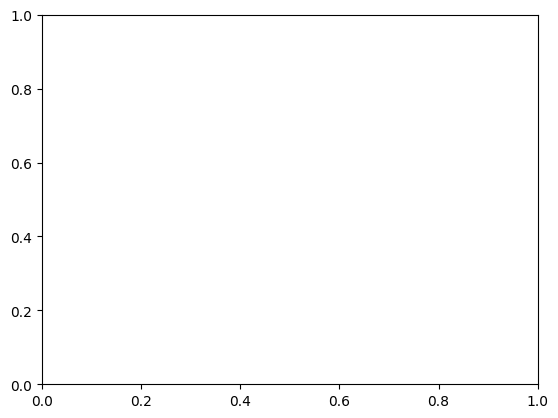

In [42]:
kmeans_player_df = player_season_allstar.drop(['ilkid', 'year', 'team'], axis=1)
kmeans_player_df= kmeans_player_df.fillna(0)

# Clustering with K-means
# Importing necessary libraries
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

#create list to hold SSE values for each k
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(kmeans_player_df)
    sse.append(kmeans.inertia_)

#visualize results
plt.plot(range(1, 35), sse)
plt.xticks(range(1, 35))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()


In [43]:
#instantiate the k-means class, using optimal number of clusters
kmeans = KMeans( n_clusters=6, random_state=45)

#fit k-means algorithm to data
k_means = kmeans.fit(kmeans_player_df)
player_season_allstar['cluster'] = kmeans.labels_
player_season_allstar

,ilkid,year,team,allstar,fg%,ft%,3p%,gp,minutes,pts,...,dreb,reb,asts,stl,blk,turnover,pf,height,weight,cluster
0,ABRAMJO01,1946,PIT,0.0,-1.818512,-0.015174,-0.700478,-0.205115,-1.229034,-0.027208,...,-0.753144,-0.951217,-0.621825,-0.790565,-0.530932,-0.825347,0.384367,-0.877512,-0.509629,2
1,AUBUCCH01,1946,DE1,0.0,-1.713148,-0.822042,-0.700478,-0.845432,-1.229034,-0.930659,...,-0.753144,-0.951217,-0.730471,-0.790565,-0.530932,-0.825347,-0.907836,-2.238568,-2.825415,2
2,BAKERNO01,1946,CH1,0.0,-4.239516,-3.778521,-0.700478,-1.824740,-1.229034,-1.057768,...,-0.753144,-0.951217,-0.875333,-0.790565,-0.530932,-0.825347,-1.424717,-1.694145,-1.108539,3
3,BALTIHE01,1946,ST1,0.0,-2.225187,-1.252773,-0.700478,0.209208,-1.229034,-0.787906,...,-0.753144,-0.951217,-0.759443,-0.790565,-0.530932,-0.825347,-0.323535,-0.605301,-0.509629,2
4,BARRJO01,1946,ST1,0.0,-1.409703,-0.538409,-0.700478,0.209208,-1.229034,-0.480889,...,-0.753144,-0.951217,-0.484206,-0.790565,-0.530932,-0.825347,0.418077,-0.877512,-0.110355,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19108,WILLISC01,2004,CLE,0.0,-1.313965,0.677416,-0.700478,-1.259754,-1.075063,-0.993236,...,-0.654231,-0.829753,-0.817388,-0.691912,-0.366499,-0.755887,-1.087621,1.027967,0.887828,0
19109,WOODSLO01,2004,TOR,0.0,0.087861,-0.640065,-0.700478,-0.280446,-0.507803,-0.713596,...,0.163452,-0.060477,-0.752200,-0.593258,0.537885,-0.311343,-0.548266,1.844601,1.486738,0
19110,WOODSQY01,2004,MIA,0.0,-0.074670,-3.778521,-0.700478,-1.862406,-1.188516,-1.038213,...,-0.726767,-0.926924,-0.875333,-0.691912,-0.530932,-0.797563,-1.357298,0.483544,0.528482,3
19111,WRIGHDO01,2004,MIA,0.0,-1.513435,1.667624,-0.700478,-1.862406,-1.201684,-1.044079,...,-0.746550,-0.947168,-0.853603,-0.691912,-0.530932,-0.783671,-1.402244,0.211333,0.089281,2


In [44]:
import numpy as np
distances = np.linalg.norm(kmeans_player_df - kmeans.cluster_centers_[kmeans.labels_], axis=1)
threshold = np.percentile(distances, 95)
outliers = kmeans_player_df[distances > threshold]
matching_outliers = player_season_allstar.loc[outliers.index]
matching_outliers['ilkid']

,ilkid
53,GETCHGO01
246,HICKEMA01
258,JORGEJO01
306,RULLOJE01
310,SAILOKE01
...,...
18961,REEDJU01
18989,SEUNGHA01
19025,TABUSYU01
19061,WADEDW01


In [45]:
from sklearn.ensemble import IsolationForest

# Fit the model
iso_forest = IsolationForest(contamination=0.05)  # 5% contamination
iso_forest.fit(kmeans_player_df)

# Predict outliers
outliers = iso_forest.predict(kmeans_player_df)
outliers = kmeans_player_df[outliers == -1]  # -1 means outlier

matching_outliers = player_season_allstar.loc[outliers.index]
matching_outliers['ilkid']


,ilkid
981,MIKANGE01
1009,SCHAYDO01
1498,COUSYBO01
1668,STOKEMA01
1767,STOKEMA01
...,...
18920,ONEASH01
18953,PRZYBJO01
19015,STOUDAM01
19061,WADEDW01


In [46]:
teams_clusters = player_season_allstar[['team', 'year', 'cluster']]

# Group by 'teams' and 'cluster', then count the occurrences of each 'cluster' for each 'team'
teams_clusters = teams_clusters.groupby(['team', 'year', 'cluster']).size().unstack(fill_value=0)
teams_clusters = teams_clusters.reset_index()
teams_clusters.columns.name = None
teams_clusters.head()

,team,year,0,1,2,3,4,5
0,ANA,1967,3,4,7,3,2,0
1,AND,1949,1,0,13,2,0,0
2,ATL,1968,1,8,3,1,0,0
3,ATL,1969,2,6,3,2,0,0
4,ATL,1970,3,6,3,0,0,0


In [47]:
# then merging with team_season data
team_season = team_season.drop(columns=[col for col in team_season.columns if col not in ['team', 'win%']])

teams_clusters = team_season.merge(
    teams_clusters,
    on=['team'],
    how='right'
)
teams_clusters.head()

,team,win%,year,0,1,2,3,4,5
0,ANA,0.320513,1967,3,4,7,3,2,0
1,AND,0.578125,1949,1,0,13,2,0,0
2,ATL,0.585366,1968,1,8,3,1,0,0
3,ATL,0.585366,1968,1,8,3,1,0,0
4,ATL,0.439024,1968,1,8,3,1,0,0


In [48]:
teams_clusters.set_index('team')
cols = ['team', 'win%', 'year', 'cluster 0', 'cluster 1', 'cluster 2', 'cluster 3','cluster 4', 'cluster 5' ]
teams_clusters.columns = cols
teams_clusters.head()

,team,win%,year,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5
0,ANA,0.320513,1967,3,4,7,3,2,0
1,AND,0.578125,1949,1,0,13,2,0,0
2,ATL,0.585366,1968,1,8,3,1,0,0
3,ATL,0.585366,1968,1,8,3,1,0,0
4,ATL,0.439024,1968,1,8,3,1,0,0


In [49]:
# Way 1 - We can turn this into a binary classification problem by using a simple heuristic
# if the team has a higher win% than their opponent, we will label them as 1
# we can iterate through the dataframe and then build a dataset of the difference
# in the features between the two teams and who the winner was
matchups = []
clusters = ['cluster 0', 'cluster 1', 'cluster 2', 'cluster 3','cluster 4', 'cluster 5' ]
final_dataframe = teams_clusters

for year in final_dataframe['year'].unique():
    year_data = final_dataframe[final_dataframe['year'] == year]
    teams = year_data['team'].unique()
    for i in range(len(teams)):
        # so we dont compare the same teams against each other again
        for j in range(len(teams)):
            if teams[i] == teams[j]:
                continue
            team1_data = year_data[year_data['team'] == teams[i]].iloc[0]
            team2_data = year_data[year_data['team'] == teams[j]].iloc[0]
            match_features = {}
            for cluster in clusters:
                match_features[cluster] = team1_data[cluster] - team2_data[cluster]

            match_features['winner'] = 1 if team1_data['win%'] > team2_data['win%'] else 0
            matchups.append(match_features)

matchups_df = pd.DataFrame(matchups)
matchups_df.head()

,cluster 0,cluster 1,cluster 2,cluster 3,cluster 4,cluster 5,winner
0,1,-2,3,2,2,0,0
1,2,-3,3,3,2,0,0
2,0,-4,5,2,2,0,0
3,-4,-1,5,1,2,0,0
4,1,-3,1,3,2,0,0


In [50]:
X = matchups_df.drop('winner', axis=1)
y = matchups_df['winner']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier()
clf.fit(X_train, y_train)
clf.score(X_test, y_test)

0.5570839064649243

In [51]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]
for f in range(X.shape[1]):
    print(f'{X.columns[indices[f]]}: {importances[indices[f]]}')

cluster 2: 0.27156227615433476
cluster 0: 0.23004820075445503
cluster 3: 0.22263873402681056
cluster 4: 0.10436143402731908
cluster 5: 0.10177267070579231
cluster 1: 0.06961668433128816


In [52]:
# Way 2 - using win% as the target

X = final_dataframe[clusters]
y = final_dataframe['win%']
y = y.fillna(0)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

from sklearn.metrics import mean_squared_error

mean_squared_error(y_test, y_pred)

0.021326148519722206

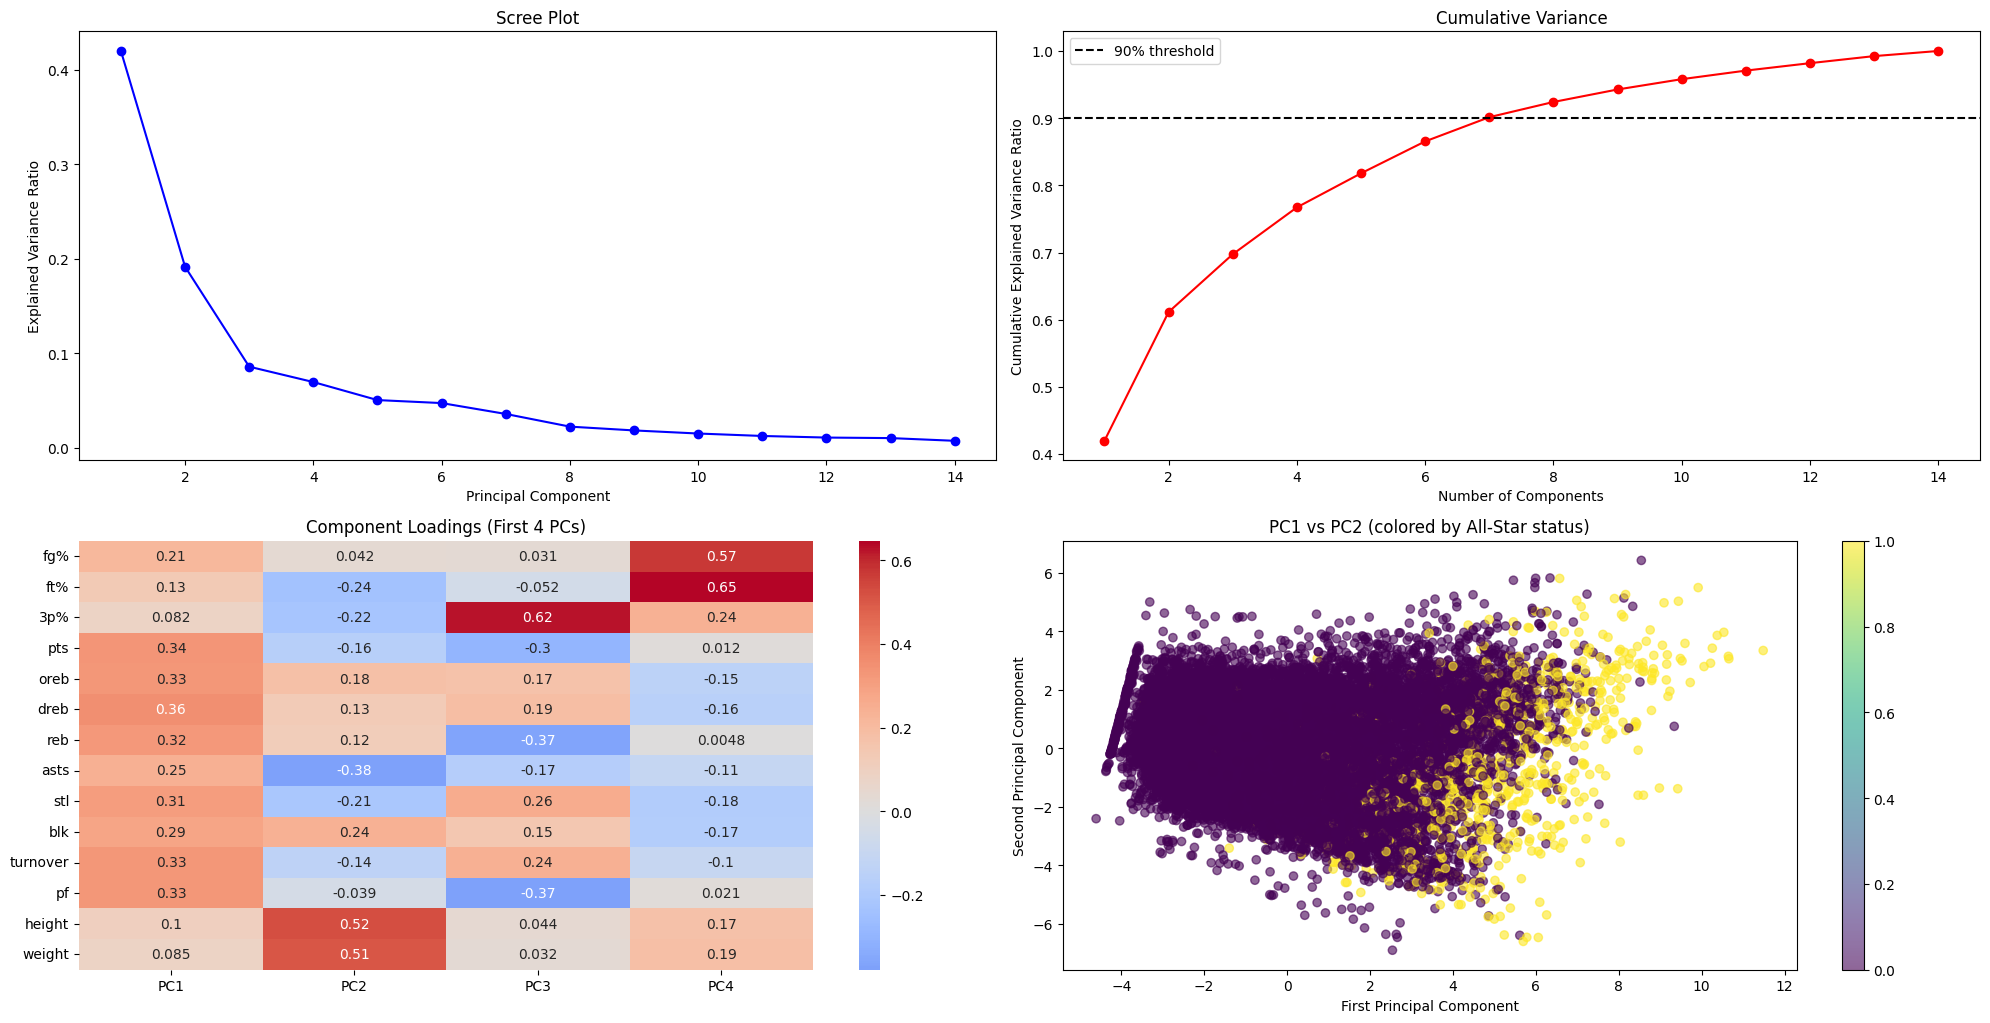

In [53]:
# First, we need to identify relevant features for PCA from the preprocessed dataset
features = [
    'fg%', 'ft%', '3p%',  # shooting percentages
    'pts', 'oreb', 'dreb', 'reb', 'asts', 'stl', 'blk',  # core stats
    'turnover', 'pf',  # miscellaneous
    'height', 'weight'  # physical attributes
]

# Import required libraries (already imported in notebook)
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def analyze_basketball_pca(player_season_allstar, features):
    """
    Perform PCA analysis on basketball player data for both star/non-star classification
    and overall player performance analysis.

    Parameters:
    player_season_allstar : pandas DataFrame
        The preprocessed basketball dataset
    features : list
        List of feature names to use for PCA

    Returns:
    dict : Dictionary containing PCA results
    """
    # Helper function for PCA analysis
    def _perform_pca(X, feature_names):
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X)

        pca = PCA()
        X_pca = pca.fit_transform(X_scaled)

        # Calculate variance ratios
        explained_variance_ratio = pca.explained_variance_ratio_
        cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

        # Create component loadings DataFrame
        loadings = pca.components_.T
        loading_df = pd.DataFrame(
            loadings,
            columns=[f'PC{i+1}' for i in range(loadings.shape[1])],
            index=feature_names
        )

        return pca, X_pca, explained_variance_ratio, cumulative_variance_ratio, loading_df

    # Prepare datasets
    X_with_allstar = player_season_allstar[features + ['allstar']].dropna()
    X_features = X_with_allstar[features]
    y_allstar = X_with_allstar['allstar']

    # Get PCA results
    pca_results = _perform_pca(X_features, features)

    # Create visualizations
    fig = plt.figure(figsize=(20, 15))

    # Scree plot
    plt.subplot(321)
    plt.plot(range(1, len(pca_results[2]) + 1), pca_results[2], 'bo-')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Scree Plot')

    # Cumulative variance
    plt.subplot(322)
    plt.plot(range(1, len(pca_results[3]) + 1), pca_results[3], 'ro-')
    plt.axhline(y=0.9, color='k', linestyle='--', label='90% threshold')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('Cumulative Variance')
    plt.legend()

    # Component loadings heatmap
    plt.subplot(323)
    sns.heatmap(pca_results[4].iloc[:, :4], annot=True, cmap='coolwarm', center=0)
    plt.title('Component Loadings (First 4 PCs)')

    # Scatter plot of first two PCs colored by All-Star status
    plt.subplot(324)
    scatter = plt.scatter(pca_results[1][:, 0], pca_results[1][:, 1],
                         c=y_allstar, cmap='viridis', alpha=0.6)
    plt.xlabel('First Principal Component')
    plt.ylabel('Second Principal Component')
    plt.title('PC1 vs PC2 (colored by All-Star status)')
    plt.colorbar(scatter)

    plt.tight_layout()
    plt.show()

    return {
        'pca_obj': pca_results[0],
        'transformed_data': pca_results[1],
        'explained_variance_ratios': pca_results[2],
        'cumulative_variance_ratios': pca_results[3],
        'component_loadings': pca_results[4]
    }

# Usage:
results = analyze_basketball_pca(player_season_allstar, features)